<a href="https://colab.research.google.com/github/Ashail33/Masters-work/blob/master/s5c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.linear_model import Lasso
import time
import scipy.sparse as sp
from scipy.sparse import spdiags
from sklearn.utils import check_random_state
from scipy.sparse import diags
from numpy.linalg import qr
from numpy.random import default_rng
from scipy.sparse import eye as speye
from scipy.sparse.linalg import norm as spnorm
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator, ClusterMixin




def do_iter(X, g_orig, w_orig, rand_idx, shrinkfactor, threshold):
    w = w_orig.copy()
    g = g_orig.copy()
    Xrows, Xcols = X.shape
    for j_iter in range(len(rand_idx)):
        j = rand_idx[j_iter] - 1  # Python index starts from 0
        wjold = w[j]
        gj = g + wjold * X[:, j]
        wjnew = np.sum(X[:, j] * gj)
        # Soft thresholding
        if wjnew >= 0:
            wjnew = (wjnew - threshold) / shrinkfactor[j] if wjnew - threshold > 0 else 0
        else:
            wjnew = (wjnew + threshold) / shrinkfactor[j] if -wjnew - threshold > 0 else 0
        g -= (wjnew - wjold) * X[:, j]
        w[j] = wjnew
    return w, g

def cdescentCycleC(X, g, w, rand_idx, shrinkfactor, threshold):
    return do_iter(X, g, w, rand_idx, shrinkfactor, threshold)

def cdescentCycle(X, r, w, rand_idx, active, norms, threshold):
    num_rand = len(rand_idx)
    if num_rand == 0:
        return w, r
    else:
        rand_idx = np.random.permutation(rand_idx)
    return cdescentCycleC(X, r, w, rand_idx, norms, threshold)


In [2]:


def mylasso(X, S, STATS, i):
    lasso = Lasso(alpha=STATS['Lambda'], fit_intercept=False, tol=STATS['reltol'])
    y = X[:, i]
    X_S = X[:, S]
    lasso.fit(X_S, y)
    STATS['W'][S, i] = lasso.coef_
    STATS['R'][:, i] = y - X_S @ lasso.coef_
    return STATS

def lassoFit(diag_col, X, w, r, threshold, reltol, norms):
    active = (w != 0)
    time_for_CD = 0
    wold = w.copy()
    while True:
        start_CD = time.time()
        rand_idx = np.setdiff1d(np.where(active)[0], diag_col)
        w, r = cdescentCycle(X, r, w, rand_idx, active, norms, threshold)
        active = (w != 0)
        time_for_CD += time.time() - start_CD
        if np.max(np.abs((w - wold) / (1.0 + np.abs(wold)))) < reltol:
            potentially_active = np.abs(r.T @ X) > threshold
            if np.any(potentially_active):
                new_active = active | potentially_active
                start_CD = time.time()
                rand_idx = np.setdiff1d(np.where(new_active)[0], diag_col)
                w, r = cdescentCycle(X, r, w, rand_idx, new_active, norms, threshold)
                new_active = (w != 0)
                time_for_CD += time.time() - start_CD
            else:
                new_active = active
            if np.array_equal(new_active, active):
                break
            else:
                active = new_active
            if np.max(np.abs((w - wold) / (1.0 + np.abs(wold)))) < reltol:
                break
        wold = w.copy()
    return w, r, time_for_CD





In [3]:


def representation_learning_S5C(X, lambda_, num_subsamples, reltol=1e-3, num_I_t=1, seed=1234, verbose=False):
    np.random.seed(seed)
    m, n = X.shape
    if n < num_subsamples:
        print('Warning: number of subsamples are set to be larger than the number of datapoints. Automatically fixed it to be number of datapoints')
        num_subsamples = n

    max_t = num_subsamples * 2
    num_rand_idx = num_subsamples * 2 * num_I_t
    if n >= num_rand_idx:
        rand_idx = np.random.permutation(n)[:num_rand_idx]
    else:
        rand_idx = np.random.choice(n, num_rand_idx)

    S_t = []  # S_t is a set of indices of subsamples at t-th iteration
    norms = np.sum(X**2, axis=0)
    stats = {
        'reltol': reltol,
        'Lambda': lambda_,
        'time_for_CD': 0,
        'time_for_fit': 0,
        'normsSt': [],
        'XSt': [],
        'W': np.zeros((num_subsamples, n)),  # C_St
        'R': X  # R = X - XC
    }

    # Select selective subsamples.
    selectiontic = time.time()
    for t in range(max_t):
        I_t = rand_idx[(t-1)*num_I_t : t*num_I_t]
        if len(S_t) != 0:
            for i in I_t:
                stats = mylasso(X, S_t, stats, i)  # You need to implement this function

        candidate = list(set(range(n)) - set(S_t))
        grad_L = stats['R'][:, I_t].T @ X[:, candidate]
        grad = np.zeros((num_I_t, n))
        grad[:, candidate] = np.minimum(grad_L+lambda_, np.maximum(0, grad_L-lambda_))
        grad[:, I_t] = 0
        max_vals, idx = np.sort(np.sum(grad**2, axis=0))[::-1], np.argsort(np.sum(grad**2, axis=0))[::-1]
        if max_vals[0] != 0:
            dSt = idx[0]  # dSt is i' in the paper
            S_t.append(dSt)
            stats['normsSt'].append(norms[dSt])
            stats['XSt'].append(X[:, dSt])
            if len(S_t) == num_subsamples:
                break
    selectiontime = time.time() - selectiontic

    # Solve all lasso with final S_t
    lassotic = time.time()
    for i in range(n):
        stats = mylasso(X, S_t, stats, i)  # You need to implement this function
    lassotime = time.time() - lassotic

    # Put C into sparse matrix format
    settic = time.time()
    num_St = len(S_t)
    row_idx = np.repeat(S_t, n)
    col_idx = np.tile(np.arange(n), num_St)
    C = sp.coo_matrix((stats['W'].ravel(), (row_idx, col_idx)), shape=(n, n))
    setctime = time.time() - settic

    # Show stats
    if verbose:
        timestats = {
            '1.selection': selectiontime,
            '2.final lasso': lassotime,
            '3.fit in all lasso': stats['time_for_fit'],
            '4.CD in fit': stats['time_for_CD'],
            '5.set C': setctime
        }
        print(timestats)

    return C, S_t


In [4]:
def litekmeans(X, k, distance='sqeuclidean', start='sample', maxit=100, reps=1, clustermaxit=10):
    n, p = X.shape

    if distance not in ['sqeuclidean', 'cosine']:
        raise ValueError("Unknown 'Distance' parameter value: %s." % distance)

    if isinstance(start, str):
        if start not in ['sample', 'cluster']:
            raise ValueError("Unknown 'Start' parameter value: %s." % start)
        elif k is None:
            raise ValueError("You must specify the number of clusters, K.")
    elif isinstance(start, np.ndarray):
        if start.shape[1] == p:
            center = start
        elif start.shape[1] == 1 or start.shape[0] == 1:
            center = X[start, :]
        else:
            raise ValueError("The 'Start' matrix must have the same number of columns as X.")
        if k is None:
            k = center.shape[0]
        elif k != center.shape[0]:
            raise ValueError("The 'Start' matrix must have K rows.")
        start = 'numeric'
    else:
        raise ValueError("The 'Start' parameter value must be a string or a numeric matrix or array.")

    if not (isinstance(k, int) and k > 0):
        raise ValueError("K must be a positive integer value.")
    elif n < k:
        raise ValueError("X must have more rows than the number of clusters.")

    bestlabel = None
    sumD = np.zeros(k)
    bCon = False

    for t in range(reps):
        if start == 'sample':
            rng = check_random_state(None)
            seeds = rng.permutation(n)[:k]
            center = X[seeds]
        elif start == 'cluster':
            rng = check_random_state(None)
            Xsubset = X[rng.permutation(n)[:int(0.1*n)]]
            _, center = litekmeans(Xsubset, k, distance=distance, start='sample', maxit=clustermaxit)
        elif start == 'numeric':
            pass

        last = np.zeros((1,n))
        label = np.ones((1,n))
        it = 0

        if distance == 'sqeuclidean':
            while np.any(label != last) and it < maxit:
                last = label
                bb = np.sum(center**2, axis=1)
                ab = X @ center.T
                D = bb - 2*ab
                val, label = np.min(D, axis=1), np.argmin(D, axis=1)
                E = np.zeros((n, k))
                E[np.arange(n), label] = 1
                center = (E.T @ X) / np.sum(E, axis=0).reshape(-1, 1)
                it += 1
            if it < maxit:
                bCon = True
            if bestlabel is None:
                bestlabel = label
                bestcenter = center
                if reps > 1:
                    if it >= maxit:
                        aa = np.sum(X**2, axis=1)
                        bb = np.sum(center**2, axis=1)
                        ab = X @ center.T
                        D = aa.reshape(-1, 1) + bb - 2*ab
                        D[D < 0] = 0
                    else:
                        aa = np.sum(X**2, axis=1)
                        D = aa.reshape(-1, 1) + D
                        D[D < 0] = 0
                    D = np.sqrt(D)
                    for j in range(k):
                        sumD[j] = np.sum(D[label==j, j])
                    bestsumD = sumD
                    bestD = D
                else:
                    pass
            else:
                if it >= maxit:
                    aa = np.sum(X**2, axis=1)
                    bb = np.sum(center**2, axis=1)
                    ab = X @ center.T
                    D = aa.reshape(-1, 1) + bb - 2*ab
                    D[D < 0] = 0
                else:
                    aa = np.sum(X**2, axis=1)
                    D = aa.reshape(-1, 1) + D
                    D[D < 0] = 0
                D = np.sqrt(D)
                for j in range(k):
                    sumD[j] = np.sum(D[label==j, j])
                if np.sum(sumD) < np.sum(bestsumD):
                    bestsumD = sumD
                    bestlabel = label
                    bestcenter = center
                    bestD = D
        elif distance == 'cosine':
            while np.any(label != last) and it < maxit:
                last = label
                center = center / np.sqrt(np.sum(center**2, axis=1)).reshape(-1, 1)
                D = 1 - X @ center.T
                val, label = np.min(D, axis=1), np.argmin(D, axis=1)
                E = np.zeros((n,
                k))
                E[np.arange(n), label] = 1
                center = (E.T @ X) / np.sum(E, axis=0).reshape(-1, 1)
                it += 1
            if it < maxit:
                bCon = True
            if bestlabel is None:
                bestlabel = label
                bestcenter = center
                if reps > 1:
                    if it >= maxit:
                        center = center / np.sqrt(np.sum(center**2, axis=1)).reshape(-1, 1)
                        D = 1 - X @ center.T
                    bestD = D
                    for j in range(k):
                        sumD[j] = np.sum(D[label==j, j])
                    bestsumD = sumD
                else:
                    pass
            else:
                if it >= maxit:
                    center = center / np.sqrt(np.sum(center**2, axis=1)).reshape(-1, 1)
                    D = 1 - X @ center.T
                bestD = D
                for j in range(k):
                    sumD[j] = np.sum(D[label==j, j])
                if np.sum(sumD) < np.sum(bestsumD):
                    bestsumD = sumD
                    bestlabel = label
                    bestcenter = center
                    bestD = D

    if reps > 1:
        return bestlabel, bestcenter, sum(bestsumD), bestD, bCon
    else:
        return bestlabel, bestcenter, bCon


def normrow(A):
    W = A.copy()
    n = W.shape[0]
    d = 1.0 / np.sum(W, axis=1)
    d[np.isinf(d)] = 0
    D = diags(d, 0)
    W = D.dot(A)
    return W


def orth_iter(A, K, err_tol, max_iter, seed=1):
    rng = default_rng(seed)
    N = A.shape[0]

    Q = rng.random((N, K))
    Q, _ = qr(Q)

    Q_prev = Q

    for _ in range(max_iter):
        Z = A @ Q
        Q, _ = qr(Z)

        if np.linalg.norm(Q - Q_prev, 'fro') / np.sqrt(N*K) < err_tol:
            break
        Q_prev = Q

    return Q


In [5]:


def spectral_clustering_S5C(W, K, err_tol=1e-5, max_iter=100, verbose=False):
    rng = default_rng(1234)

    N = W.shape[0]

    isolated = (np.sum(W, axis=0) == 0)
    connected = ~isolated
    W = W[connected][:, connected]
    Nold = N
    N = W.shape[0]

    D = diags(np.sum(W, axis=0), format='csr')
    L = D - W  # unnormalized Laplacian

    DN = diags(1.0 / np.sqrt(np.sum(W, axis=0)), format='csr')
    Lsym = speye(N, format='csr') - DN @ W @ DN  # normalized Laplacian

    lambda_max = 2

    # eigenvectors corresponding to smallest eigenvalues of L_sym
    # are eigenvectors corresponding to largest eigenvalues of L_max

    Lmax = lambda_max * speye(N, format='csr') - Lsym

    U = orth_iter(Lmax.toarray(), K, err_tol, max_iter)

    # normalize U
    for i in range(N):
        U[i, :] = U[i, :] / np.linalg.norm(U[i, :])

    N = Nold

    kmeans = KMeans(n_clusters=K, max_iter=200, n_init=20, random_state=rng)
    A = kmeans.fit_predict(U)

    if A.shape[0] != N:
        tmp = rng.integers(low=0, high=K, size=N)
        tmp[connected] = A
        A = tmp

    if verbose:
        timestats = {'1. spectral': spectral_clustering_time, '2. kmeans': kmeans_time}
        print(timestats)

    return A


In [6]:

def run_S5C(Y, A0, L, numS):
    # for reproducible results
    np.random.seed(25)

    print('Running S5C..')

    elapsed_times = []
    clustering_errors = []

    for plambda in range(1, 11):
        np.random.seed(25)
        lambda_ = 2 ** -plambda

        start1 = time.time()
        C, _ = representation_learning_S5C(normalize(Y, axis=0), lambda_, numS)
        elapsed_time_1 = time.time() - start1

        W = np.abs(C) + np.abs(C.T)

        start2 = time()
        A = spectral_clustering_S5C(W, L)
        elapsed_time_2 = time.time() - start2

        elapsed_times.append(elapsed_time_1 + elapsed_time_2)
        clustering_errors.append(clustering_error(A, A0))

    return clustering_errors, elapsed_times


In [7]:
class SpectralClusteringS5C(BaseEstimator, ClusterMixin):
    def __init__(self, K,gamma=0.5, err_tol=1e-5, max_iter=100, verbose=False, random_state=1234):
        self.K = K
        self.err_tol = err_tol
        self.gamma=gamma
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_state = random_state
        self.labels_ = None

    def fit(self, X):
        W = rbf_kernel(X, gamma=self.gamma)
        lambda_max = 2

        N = W.shape[0]
        isolated = (np.sum(W, axis=0) == 0)
        connected = ~isolated
        W = W[connected][:, connected]
        Nold = N
        N = W.shape[0]

        D = diags(np.sum(W, axis=0), format='csr')
        L = D - W  # unnormalized Laplacian

        DN = diags(1.0 / np.sqrt(np.sum(W, axis=0)), format='csr')
        Lsym = speye(N, format='csr') - DN @ W @ DN  # normalized Laplacian

        Lmax = lambda_max * speye(N, format='csr') - Lsym

        # Convert Lmax to a numpy.ndarray
        Lmax = np.array(Lmax)

        U = orth_iter(Lmax, self.K, self.err_tol, self.max_iter)

        # normalize U
        for i in range(N):
            U[i, :] = U[i, :] / np.linalg.norm(U[i, :])

        N = Nold

        kmeans = KMeans(n_clusters=self.K, max_iter=200, n_init=20, random_state=self.random_state)
        self.labels_ = kmeans.fit_predict(U)

        if self.labels_.shape[0] != N:
            rng = np.random.default_rng(self.random_state)
            tmp = rng.integers(low=0, high=self.K, size=N)
            tmp[connected] = self.labels_
            self.labels_ = tmp

        return self


<ipython-input-8-d9e140392f72>:48: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


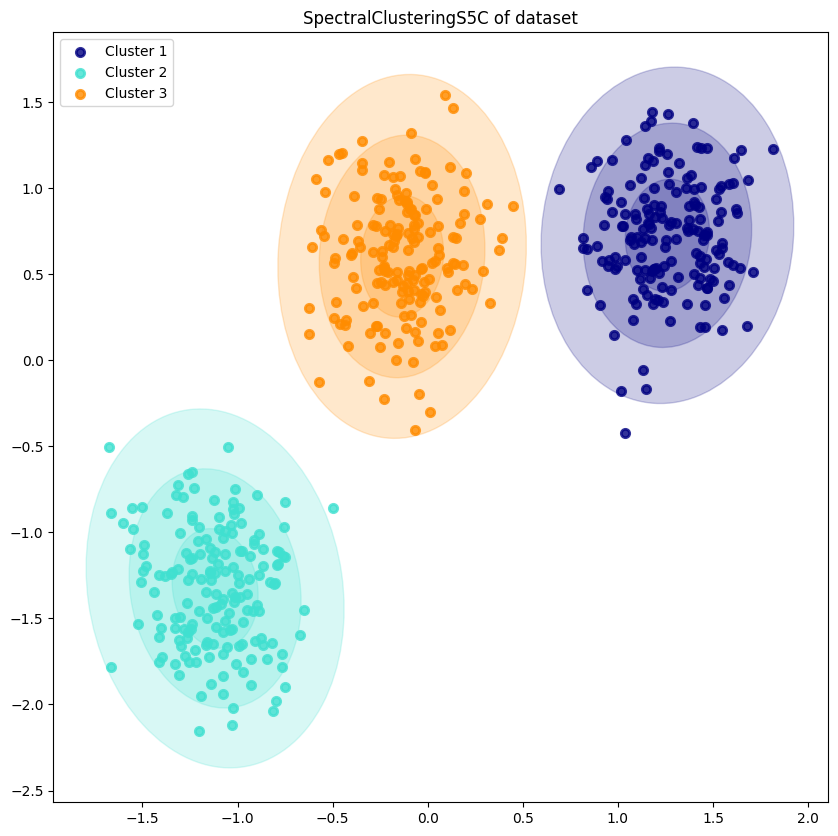

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate sample data
n_samples = 500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Normalize the data
X = StandardScaler().fit_transform(X)


from sklearn.metrics.pairwise import rbf_kernel

# Compute the similarity matrix
gamma = 0.1  # Parameter for the RBF kernel
# W = rbf_kernel(X, gamma=gamma)

# Apply SpectralClusteringS5C
clustering = SpectralClusteringS5C(K=3)
clustering.fit(X)
labels = clustering.labels_

# # Apply SpectralClusteringS5C
# clustering = SpectralClusteringS5C(K=3)
# clustering.fit(X)
# labels = clustering.labels_

# Function to draw confidence ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# Visualize the results
plt.figure(figsize=(10, 10))
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], ["Cluster 1", "Cluster 2", "Cluster 3"]):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
    draw_ellipse(np.mean(X[labels == i], axis=0), np.cov(X[labels == i].T), color=color, alpha=0.2)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('SpectralClusteringS5C of dataset')
plt.show()


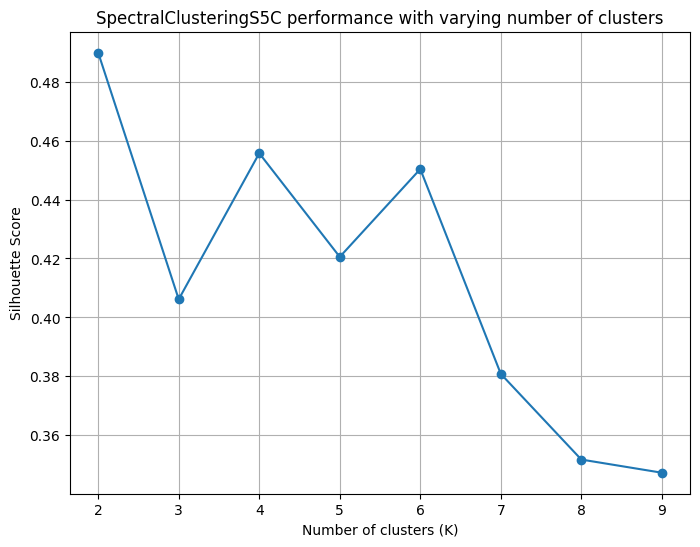

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score

# Generate a moons dataset
X, y = make_moons(n_samples=500, noise=0.05, random_state=0)

# List to store the results
silhouette_scores = []

# Range of clusters to test
clusters_range = range(2, 10)

for K in clusters_range:
    # Initialize and fit the SpectralClusteringS5C model
    clustering = SpectralClusteringS5C(K=K, random_state=0)
    clustering.fit(X)

    # Compute the silhouette score and append to the results list
    score = silhouette_score(X, clustering.labels_)
    silhouette_scores.append(score)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.title('SpectralClusteringS5C performance with varying number of clusters')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


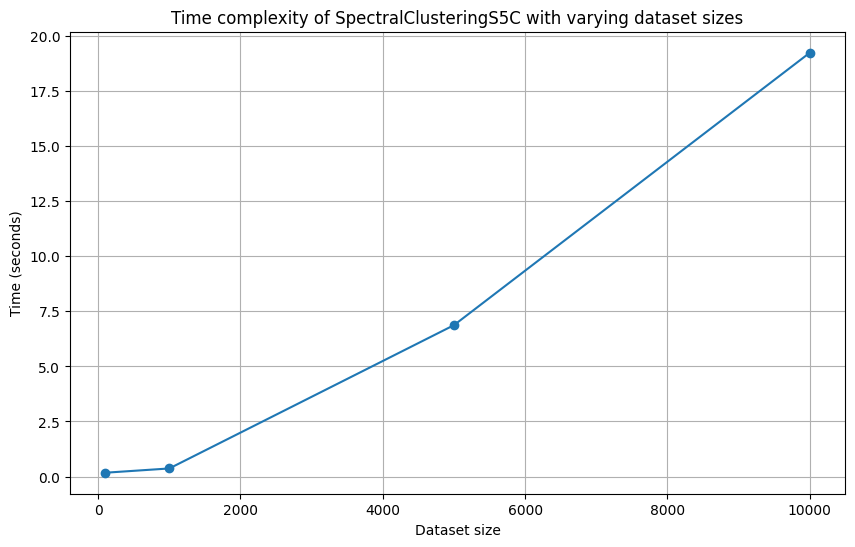

In [10]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Define the dataset sizes
dataset_sizes = [100, 1000, 5000, 10000]

# Set a fixed number of clusters
K = 5

# Initialize the results list
results = []

# For each dataset size
for size in dataset_sizes:
    # Generate a dataset
    X, y = make_moons(n_samples=size, noise=0.05, random_state=0)

    # Initialize and fit the SpectralClusteringS5C model
    clustering = SpectralClusteringS5C(K=K, random_state=0)

    # Record the start time
    start_time = time.time()

    # Fit the model
    clustering.fit(X)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Store the results
    results.append(elapsed_time)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, results, marker='o')
plt.xlabel('Dataset size')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.title('Time complexity of SpectralClusteringS5C with varying dataset sizes')
plt.show()


In [11]:
!pip install memory-profiler

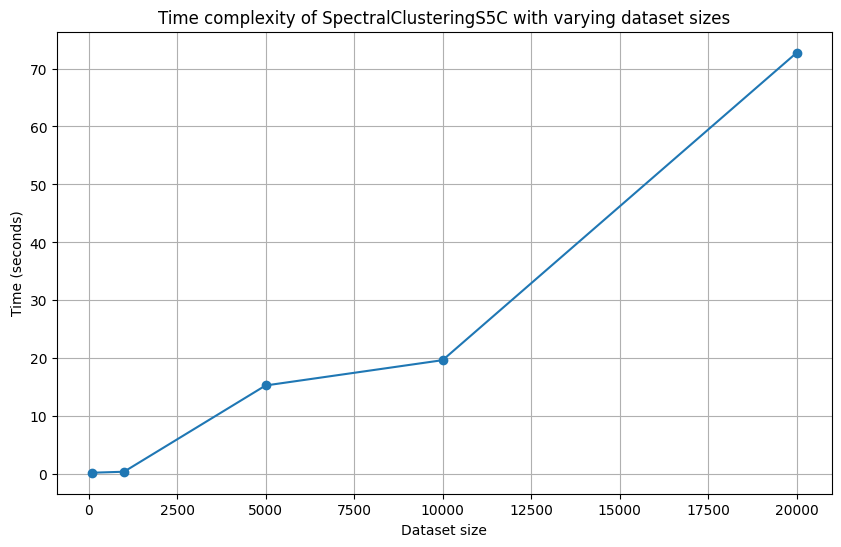

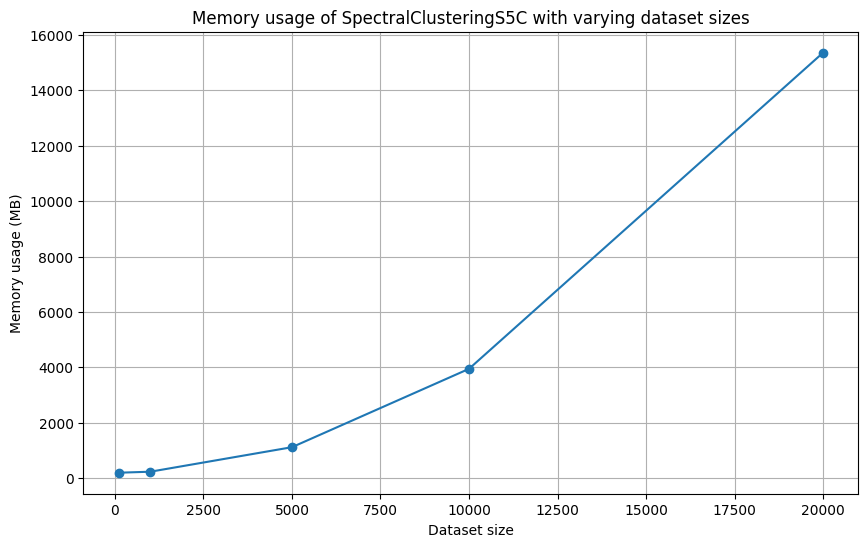

In [12]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from memory_profiler import memory_usage

# Define the dataset sizes
dataset_sizes = [100, 1000, 5000, 10000,20000]

# Set a fixed number of clusters
K = 5

# Initialize the results list for time and memory
time_results = []
memory_results = []

# For each dataset size
for size in dataset_sizes:
    # Generate a dataset
    X, y = make_moons(n_samples=size, noise=0.05, random_state=0)

    # Initialize and fit the SpectralClusteringS5C model
    clustering = SpectralClusteringS5C(K=K, random_state=0)

    # Record the start time
    start_time = time.time()

    # Measure the memory usage of the fit method
    mem_usage = memory_usage((clustering.fit, (X,)), interval=0.1, timeout=1, max_usage=True)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Store the results
    time_results.append(elapsed_time)
    memory_results.append(mem_usage)

# Plot the time results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, time_results, marker='o')
plt.xlabel('Dataset size')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.title('Time complexity of SpectralClusteringS5C with varying dataset sizes')
plt.show()

# Plot the memory results
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, memory_results, marker='o')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage (MB)')
plt.grid(True)
plt.title('Memory usage of SpectralClusteringS5C with varying dataset sizes')
plt.show()


<ipython-input-13-ae1658d82b9d>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
<ipython-input-13-ae1658d82b9d>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  draw_ellipse(np.mean(X[labels == i], axis=0), np.cov(X[labels == i].T), color=color, alpha=0.2)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divi

LinAlgError: ignored

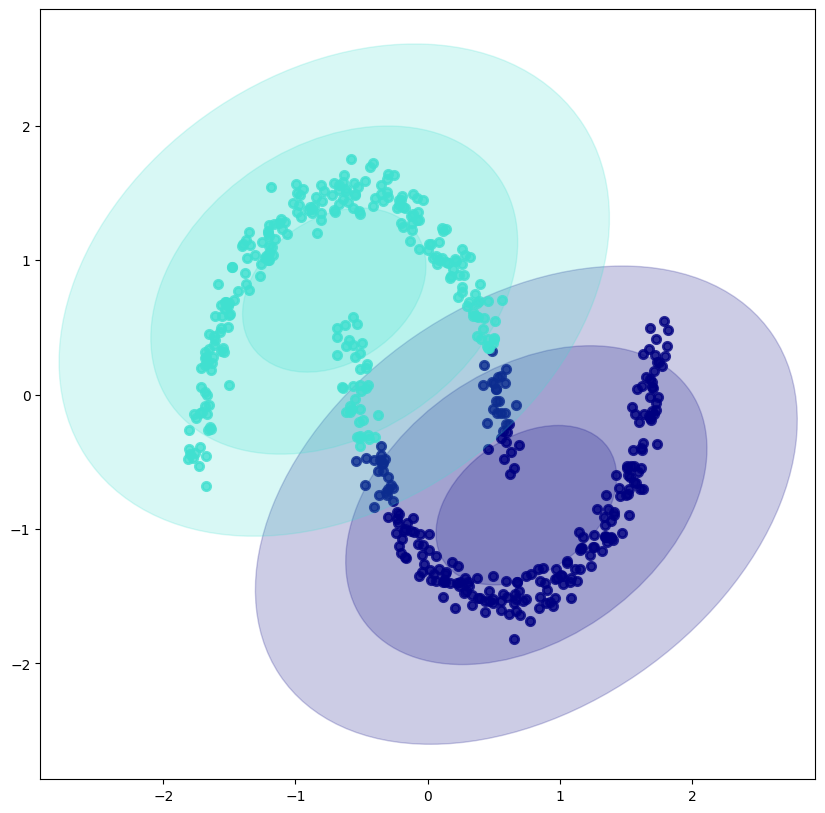

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler

# Define the dataset sizes
dataset_sizes = [100000]

# Set a fixed number of clusters
K = 2

# Define the datasets
datasets = {
    "moons": make_moons,
    "circles": make_circles
}

# Initialize the results dictionary
results = {name: [] for name in datasets}

# Function to draw confidence ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# For each dataset
for name, dataset in datasets.items():
    # Generate a dataset
    X, y = dataset(n_samples=500, noise=0.05, random_state=0)

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Initialize and fit the SpectralClusteringS5C model
    clustering = SpectralClusteringS5C(K=K, random_state=0)
    clustering.fit(X)
    labels = clustering.labels_

    # Visualize the results
    plt.figure(figsize=(10, 10))
    colors = ['navy', 'turquoise', 'darkorange']
    for color, i, target_name in zip(colors, [0, 1, 2], ["Cluster 1", "Cluster 2", "Cluster 3"]):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
        draw_ellipse(np.mean(X[labels == i], axis=0), np.cov(X[labels == i].T), color=color, alpha=0.2)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(f'SpectralClusteringS5C of {name} dataset')
    plt.show()


<ipython-input-17-9ddb77226a00>:43: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


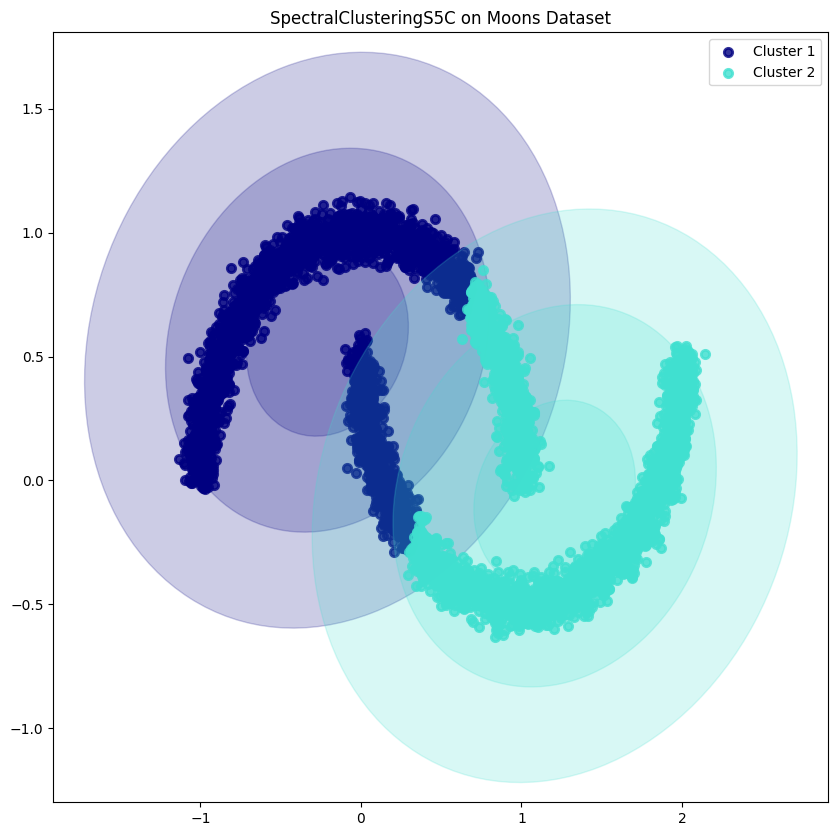

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering

# Generate sample data (moons dataset)
n_samples = 5000
noise = 0.05
X, y = make_moons(n_samples=n_samples, noise=noise,)

# Normalize the data
# X = StandardScaler().fit_transform(X)

# Compute the similarity matrix
gamma = 1.0  # Parameter for the RBF kernel
# W = rbf_kernel(X, gamma=gamma)

# Apply SpectralClusteringS5C
K = 2  # Number of clusters
clustering = SpectralClusteringS5C(K=K, random_state=0,gamma=0.1)
clustering.fit(X)
labels = clustering.labels_

# Function to draw confidence ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# Visualize the results
plt.figure(figsize=(10, 10))
colors = ['navy', 'turquoise']
for color, i, target_name in zip(colors, [0, 1], ["Cluster 1", "Cluster 2"]):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
    draw_ellipse(np.mean(X[labels == i], axis=0), np.cov(X[labels == i].T), color=color, alpha=0.2)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('SpectralClusteringS5C on Moons Dataset')
plt.show()
